In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()
sys.path.insert(0,'..')
%matplotlib inline

In [3]:
def smape(y, y_hat, eps=0.1):
    summ = np.maximum(np.abs(y) + np.abs(y_hat) + eps, 0.5 + eps)
    smape = 2. * np.abs(y_hat - y) / summ
    return smape

In [4]:
def regr_metrics(y, y_hat):
    assert y.shape == y_hat.shape
    return {
        'mse': np.mean(np.square(y - y_hat)),
        'mae': np.mean(np.abs(y - y_hat)),
        'smape': np.mean(smape(y, y_hat))
    }

In [11]:
def smooth(x,w=0.6):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

### Dataset
Experiments are conducted on the sm1 dataset that can be found [here](https://drive.google.com/drive/u/0/folders/0B3B22Hd5PMxSaVpsYmRHU2ZJYWc). The task is to predict the temperature of the sensor in the living room of the next 24 hours, given the previous 24 hours observation of each feature of the dataset.

In [6]:
dataset = pd.read_csv('../data/benchmark/sm1_2010.csv', index_col=0)
dataset.head()

,temperature_comedor_sensor,temperature_habitacion_sensor,weather_temperature,co2_comedor_sensor,co2_habitacion_sensor,humedad_comedor_sensor,humedad_habitacion_sensor,lighting_comedor_sensor,lighting_habitacion_sensor,precipitacion,...,meteo_exterior_sol_oest,meteo_exterior_sol_est,meteo_exterior_sol_sud,meteo_exterior_piranometro,exterior_entalpic_1,exterior_entalpic_2,exterior_entalpic_turbo,temperature_exterior_sensor,humedad_exterior_sensor,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2012-03-13,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,...,9690.24,12604.20,95436.8,758.880,0,0,0,18.1150,48.3750,2.0
2012-03-13,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,...,11022.00,10787.20,95436.8,762.069,0,0,0,18.4147,47.8080,2.0
2012-03-13,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,...,13960.50,9669.63,95398.6,766.251,0,0,0,18.8533,47.4320,2.0
2012-03-13,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,...,18511.20,9648.13,95360.3,766.037,0,0,0,19.2907,47.0240,2.0
2012-03-13,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,...,26349.00,9208.32,95354.9,762.743,0,0,0,19.7400,45.4743,2.0


In [7]:
dataset.columns.tolist()

['temperature_comedor_sensor',
 'temperature_habitacion_sensor',
 'weather_temperature',
 'co2_comedor_sensor',
 'co2_habitacion_sensor',
 'humedad_comedor_sensor',
 'humedad_habitacion_sensor',
 'lighting_comedor_sensor',
 'lighting_habitacion_sensor',
 'precipitacion',
 'meteo_exterior_crepusculo',
 'meteo_exterior_viento',
 'meteo_exterior_sol_oest',
 'meteo_exterior_sol_est',
 'meteo_exterior_sol_sud',
 'meteo_exterior_piranometro',
 'exterior_entalpic_1',
 'exterior_entalpic_2',
 'exterior_entalpic_turbo',
 'temperature_exterior_sensor',
 'humedad_exterior_sensor',
 'day_of_week']

In [8]:
dataset.shape

(4137, 22)

### Training and test split
The dataset is split in training and testset as in the original paper.

#### Model
The chosen model is a seq2seq model, with a single layer GRU unit with residual wrapper and dropout. The seq2seq is equipped with an attention mechanism in the encoder, that attends wrt the inputs as in [DARNN](https://arxiv.org/abs/1704.02971), which is implemented in ntsa/models/blocks as InputAttention.
In the kaf variation we add a Kaf non linearity after the memory layer as:

$$
x = softmax(k(x) + x)
$$

Where Kaf is implemented at ntsa/utils/tf_utils.py Kaf, with a dictionary $D=(-1,1)$ of 20 elements, $\gamma = 0.0315$ and the weights initialized via Ridge regression, the chosen kernel is a 1D rbf kernel, and the $\alpha$ is of size 128 units, the same as the size of the internal state of the gru cell.

```python
class InputAttention(Attention):

    def __init__(self,
                 output_shape,
                 memory,
                 name='input_attention',
                 use_bias=False,
                 alpha=0):
        super(InputAttention, self).__init__(
            output_shape=output_shape,
            memory=tf.transpose(memory, (0, 2, 1)),
            name=name,
        )
        if alpha:
            k = Kaf(input_shape=alpha)
            self._act = lambda x: tf.nn.softmax(k(x) + x)
        else:
            self._act = tf.nn.softmax
        self._memory_layer = tf.layers.Dense(units=1, use_bias=use_bias, name='memory', activation=None)
        self._input_shape = memory.get_shape()[-1]

    def apply(self, query, state, t):
        # batch_size, input_shape, cell_size + seq_len
        x = tf.concat([tf.tile(tf.expand_dims(state, axis=1), (1, self._input_shape, 1)), self._memory], axis=2)
        x = self._memory_layer(x)
        x = tf.squeeze(x, axis=2)
        alpha = self._act(x)
        x_tilde = tf.multiply(alpha, query)
        return x_tilde, state
```

### Training
Each network is trained for 100000 steps. Training parameters can be found in ntsa/config.gin. We tracked several loss function as well ad the norm of the gradient, at each training step.

In [54]:
df = pd.read_csv('../logs/darnn//ntsa-2018-12-08-14-23-35/train/results.csv')
df_kaf = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-24-35/train/results.csv')
df_kaf_dual = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-25-00/train/results.csv')

In [55]:
df.head()

,loss,norm,mse,mae,smape,rmse,mape
0,1.988717,1.969485,4.146125,1.988717,1.805780,1.988717,97.389465
1,0.065881,3.998537,0.009291,0.065881,0.098573,0.065881,45.884007
2,0.032754,11.518392,0.001744,0.032754,0.058788,0.032754,25.609791
3,0.040418,1.166554,0.002952,0.040418,0.101097,0.040418,34.624023
4,0.031454,2.784929,0.002084,0.031454,0.084743,0.031454,29.505035


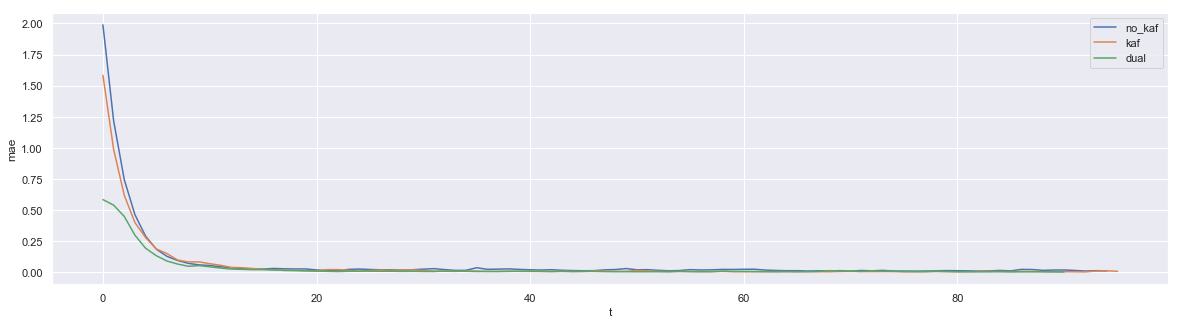

In [56]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.loss.values))
ax.plot(smooth(df_kaf.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['no_kaf','kaf', 'dual'])

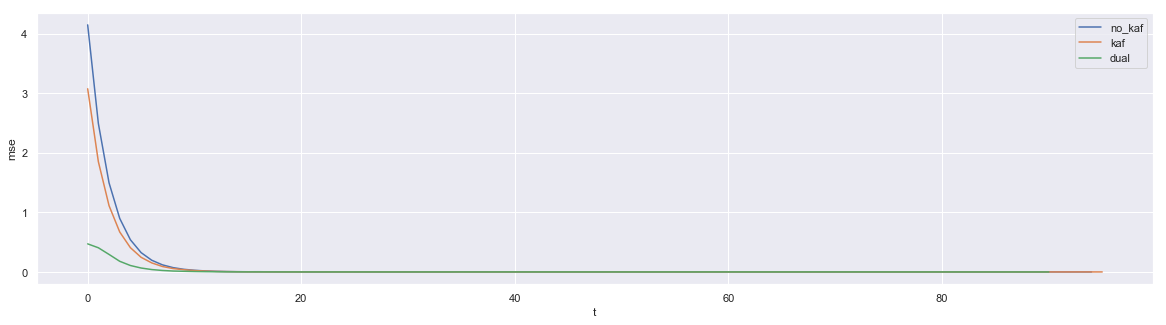

In [57]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.mse.values))
ax.plot(smooth(df_kaf.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mse')
plt.xlabel('t')
plt.legend(['no_kaf','kaf', 'dual'])

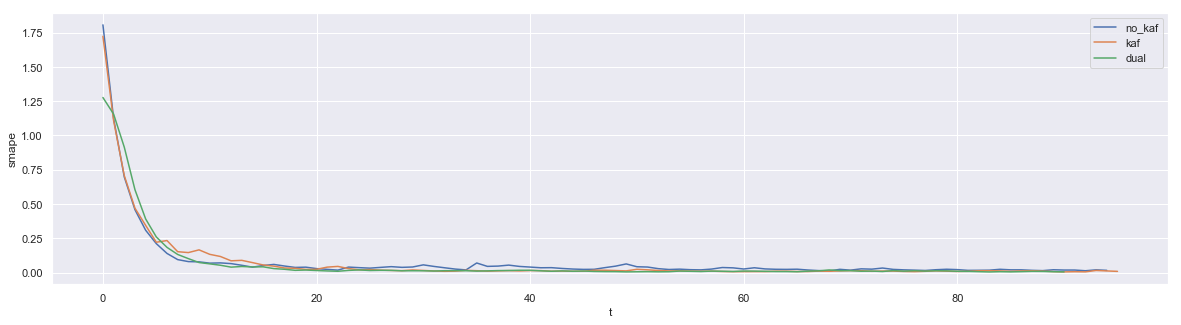

In [58]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.smape.values))
ax.plot(smooth(df_kaf.smape.values))
ax.plot(smooth(df_kaf_dual.smape.values))
plt.ylabel('smape')
plt.xlabel('t')
plt.legend(['no_kaf','kaf', 'dual'])

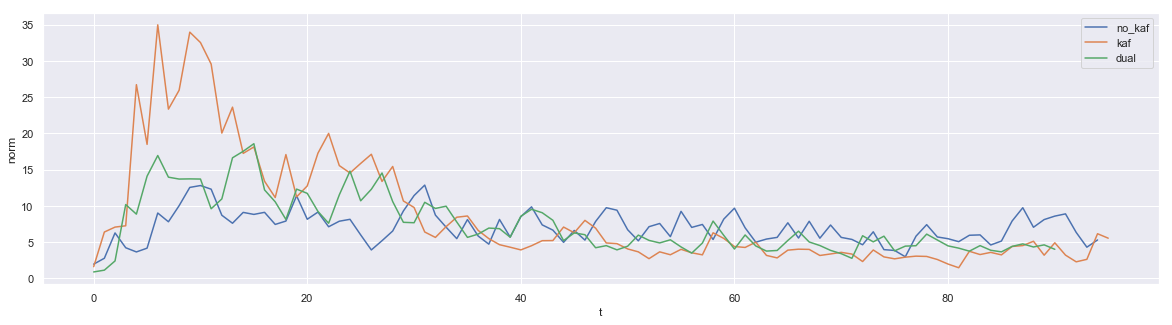

In [59]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.norm.values))
ax.plot(smooth(df_kaf.norm.values))
ax.plot(smooth(df_kaf_dual.norm.values))
plt.ylabel('norm')
plt.xlabel('t')
plt.legend(['no_kaf','kaf', 'dual'])

In [60]:
rows = ['no_kaf', 'kaf', 'kaf_dual']
table = pd.concat([df.mean(axis=0), df_kaf.mean(axis=0), df_kaf_dual.mean(axis=0)], axis=1)
table.columns =rows
table.T

,loss,norm,mse,mae,smape,rmse,mape
no_kaf,0.041981,7.112267,0.044668,0.041981,0.053402,0.041981,18.631259
kaf,0.032620,8.651013,0.033014,0.032620,0.046269,0.032620,15.144673
kaf_dual,0.025808,7.445947,0.010335,0.025808,0.048181,0.025808,27.967414


### Test and evaluation
A complete test evaluation is recored every 5000 steps and here we report the last one, for each metric.

In [61]:
df = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-23-35/test/results.csv')
df_kaf = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-24-35/test/results.csv')
df_kaf_dual = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-25-00/test/results.csv')

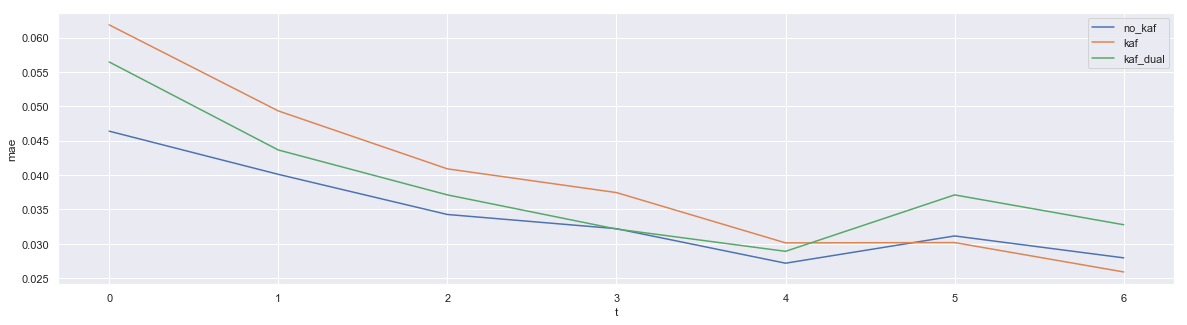

In [62]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df.loss.values))
ax.plot(smooth(df_kaf.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['no_kaf','kaf', 'kaf_dual'])

In [63]:
rows = ['no_kaf', 'kaf', 'kaf_dual']
table = pd.concat([df.mean(axis=0), df_kaf.mean(axis=0), df_kaf_dual.mean(axis=0)], axis=1)
table.columns =rows
table.T

,loss,norm,mse,mae,smape,rmse,mape
no_kaf,0.030235,4.732053,0.004950,0.030235,0.035094,0.030235,6.475966
kaf,0.031700,4.653362,0.011470,0.031700,0.032488,0.031700,4.869961
kaf_dual,0.033242,4.809456,0.011595,0.033242,0.033867,0.033242,5.306336


### Predictions

In [64]:
df = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-23-35/report/0_report.csv', index_col=0)
df_kaf = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-24-35/report/0_report.csv', index_col=0)
df_kaf_dual = pd.read_csv('../logs/darnn/ntsa-2018-12-08-14-25-00/report/0_report.csv', index_col=0)

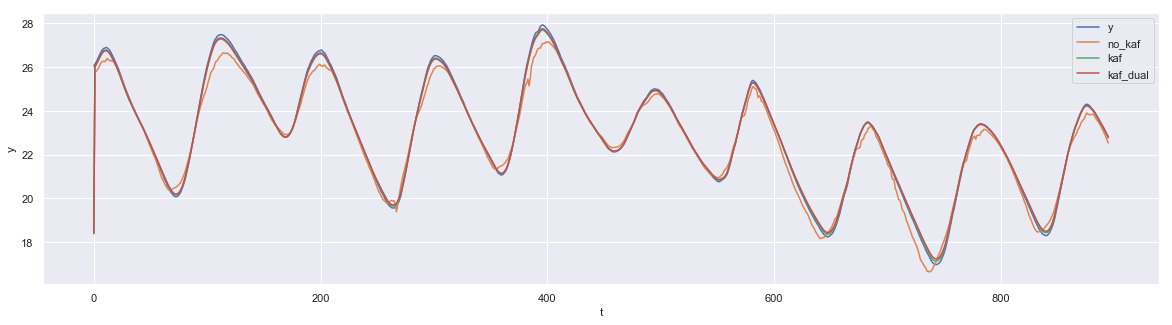

In [65]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df.y.values)
ax.plot(df.y_hat.values)
ax.plot(df_kaf.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y','no_kaf','kaf', 'kaf_dual'])

In [66]:
from ntsa.utils.misc import regr_metrics

In [67]:
y = df.y.values
y_no_kaf = df.y_hat.values
y_kaf = df_kaf.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

In [68]:
metrics = [
list(regr_metrics(y, y_no_kaf).values()),
list(regr_metrics(y, y_kaf).values()),
list(regr_metrics(y, y_kaf_dual).values()),]

In [69]:
pd.DataFrame(np.array(metrics), index=['no_kaf', 'kaf', 'dual'], columns=['mse', 'mae', 'smape', 'mape'])

,mse,mae,smape,mape
no_kaf,0.199672,0.286858,0.012660,1.285939
kaf,0.073281,0.080125,0.003487,0.357585
dual,0.074080,0.084023,0.003826,0.390858


### Conclusion
We notice that we beat the state of the art (yuhu)